In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [422]:
tickerSymbol = 'AAPl'   #EMG.L
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d',start='2017-4-1',end='2022-6-1',)
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-03 00:00:00-04:00,33.768538,33.864876,33.613452,33.766186,79942800,0.0,0.0
2017-04-04 00:00:00-04:00,33.660439,34.045801,33.641640,34.017605,79565600,0.0,0.0
2017-04-05 00:00:00-04:00,33.888380,34.179752,33.792038,33.841385,110871600,0.0,0.0
2017-04-06 00:00:00-04:00,33.904823,33.958870,33.707443,33.756790,84596000,0.0,0.0
2017-04-07 00:00:00-04:00,33.773232,33.878971,33.665145,33.681591,66688800,0.0,0.0


In [423]:
#tickerDfResample = pd.DataFrame(tickerDf.resample('2d').sum())
#tickerDfResample[tickerDfResample == 0] = None
#tickerDfResample = tickerDfResample.interpolate(method='linear')
#tickerDfResample.index = pd.to_datetime(tickerDfResample.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
#tickerDfResample
tickerDfResample = tickerDf
tickerDfResample = tickerDfResample.reset_index()

In [424]:
tickerDfResample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          1300 non-null   datetime64[ns, America/New_York]
 1   Open          1300 non-null   float64                         
 2   High          1300 non-null   float64                         
 3   Low           1300 non-null   float64                         
 4   Close         1300 non-null   float64                         
 5   Volume        1300 non-null   int64                           
 6   Dividends     1300 non-null   float64                         
 7   Stock Splits  1300 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
memory usage: 81.4 KB


In [425]:
first_diff = tickerDfResample.Close.values[1:]-tickerDfResample.Close.values[:-1]
first_diff = np.concatenate([first_diff,[0]])
tickerDfResample['FirstDifference'] = first_diff
#tickerDf.Close.pct_change().dropna()
tickerDfResample

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference
0,2017-04-03 00:00:00-04:00,33.768538,33.864876,33.613452,33.766186,79942800,0.0,0.0,0.251419
1,2017-04-04 00:00:00-04:00,33.660439,34.045801,33.641640,34.017605,79565600,0.0,0.0,-0.176220
2,2017-04-05 00:00:00-04:00,33.888380,34.179752,33.792038,33.841385,110871600,0.0,0.0,-0.084595
3,2017-04-06 00:00:00-04:00,33.904823,33.958870,33.707443,33.756790,84596000,0.0,0.0,-0.075199
4,2017-04-07 00:00:00-04:00,33.773232,33.878971,33.665145,33.681591,66688800,0.0,0.0,-0.039940
...,...,...,...,...,...,...,...,...,...
1295,2022-05-24 00:00:00-04:00,140.381810,141.538287,136.912397,139.933182,104132700,0.0,0.0,0.159515
1296,2022-05-25 00:00:00-04:00,138.009041,141.358824,137.919318,140.092697,92482700,0.0,0.0,3.250076
1297,2022-05-26 00:00:00-04:00,136.972206,143.901068,136.722966,143.342773,90601500,0.0,0.0,5.842178
1298,2022-05-27 00:00:00-04:00,144.947876,149.224823,144.818266,149.184952,90978500,0.0,0.0,-0.797562


In [426]:
def ad_test(dataset):
    dftest = adfuller(dataset,autolag = 'AIC')
    print("1. ADF: ",dftest[0])
    print("2. P_value: ",dftest[1])
    print("3. num_lags: ",dftest[2])
    print("4. : ",dftest[3])
    print("5. crit_value: ",dftest[4])
    for key,val in dftest[4].items():
        print("\t",key,": ",val)

In [427]:
ad_test(tickerDfResample['FirstDifference'])

1. ADF:  -13.166533391930844
2. P_value:  1.2756177910848635e-24
3. num_lags:  7
4. :  1292
5. crit_value:  {'1%': -3.4354214704688113, '5%': -2.863779629316101, '10%': -2.567962394851863}
	 1% :  -3.4354214704688113
	 5% :  -2.863779629316101
	 10% :  -2.567962394851863


In [428]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [429]:
stepwise_fit = auto_arima(tickerDfResample['Close'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5313.795, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5313.430, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5309.022, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5308.897, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5314.326, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5310.616, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5310.781, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5312.582, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5310.265, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.202 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1300
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2651.449
Date:                Mon, 23 Jan 2023   AIC                           5308.897
Time:                        21:48:11   BIC                           5324.405
Sample:                             0   HQIC                          5314.716
                               - 1300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0882      0.048      1.833      0.067      -0.006       0.183
ma.L1         -0.0717      0.017     -4.106      0.000      -0.106      -0.037
sigma2         3.4708      0.072     48.115      0.000       3.329       3.612
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1453.89
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              15.46   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [491]:
trainData = pd.DataFrame(tickerDfResample['Close'][600:700])
testData = pd.DataFrame(tickerDfResample['Close'][700:710])

In [492]:
len(trainData),len(testData)

(100, 10)

In [493]:
#df.asfreq('W')
#pd.infer_freq(trainData.index)

In [494]:
model = ARIMA(trainData['Close'].values,order=(0,1,1))

In [495]:
modelFit = model.fit()

In [496]:
print(modelFit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -117.918
Date:                Mon, 23 Jan 2023   AIC                            239.837
Time:                        21:55:18   BIC                            245.027
Sample:                             0   HQIC                           241.937
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0680      0.116      0.586      0.558      -0.160       0.295
sigma2         0.6340      0.096      6.637      0.000       0.447       0.821
Ljung-Box (L1) (Q):                   0.99   Jarque-

In [497]:
testData

,Close
700,76.581406
701,76.253204
702,77.208389
703,78.063141
704,77.534126
705,77.810890
706,78.185623
707,77.960297
708,75.667847
709,77.808434


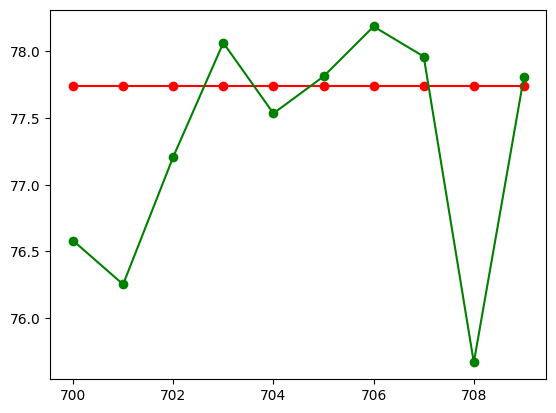

In [498]:
pred = modelFit.predict(start = len(trainData) ,end =  len(trainData)+len(testData)-1) # predcits via index weirdly
pred_train = modelFit.predict(start = 0 ,end =  len(trainData)-1) # predcits via index weirdly
futureForcast = modelFit.forecast(100)
testData['Predictions'] = pred
trainData['Predictions'] = pred_train

#plt.plot(trainData['Predictions'])
#plt.plot(trainData['Close'])

plt.plot(testData['Predictions'],"-ro")
plt.plot(testData['Close'],"-go")
#plt.plot(futureForcast)

In [877]:
#pred.index = pd.to_datetime(pred.index, format = '%m/%d/%Y').strftime('%m/%d/%Y')

In [303]:
modelFit.plot_predict()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

In [ ]:
#arima is predicting as best it can , and its best is simply a straight line for this data set